In [1]:
import xarray as xr
import glob
import intake
import numpy as np

# import warnings
# warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
from matplotlib import colors, cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar
# ProgressBar().register()

import dask
from dask.distributed import Client
client = Client(threads_per_worker=2, n_workers=14)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45437,Workers: 14
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:45423,Total threads: 2
Dashboard: /proxy/39565/status,Memory: 8.94 GiB
Nanny: tcp://127.0.0.1:34621,


In [3]:
cat_name = "barpa"
col = intake.open_esm_datastore(f"/g/data/lp01/collections/py3.9_dev/nci-{cat_name}.json")

# Edit this cell
var_list = ["ua200", "ua250", "ua300", "va200", "va250", "va300", "ta200", "ta250", "ta300", "zg200", "zg250", "zg300"]
table_id = "6hr"
scenarios = ["historical","ssp126", "ssp370", "ssp585", "evaluation"]

# change this query to select a subset of the data you are interested in
query = dict(variable_id = var_list[0],
             table_id = table_id,
             experiment_id = scenarios,
            )

cat = col.search(**query)
cat.unique()

activity_id                                                    [BARPA-R]
institution_id                                                     [BOM]
version                                                      [v20231001]
variable_id                                                      [ua200]
table_id                                                           [6hr]
source_id              [ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, ...
experiment_id           [historical, ssp126, ssp370, ssp585, evaluation]
member_id                      [r4i1p1f1, r6i1p1f1, r11i1p1f1, r1i1p1f1]
grid_label                                                      [AUS-15]
time_range             [196001-196012, 196101-196112, 196201-196212, ...
path                   [/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM...
derived_variable_id                                                   []
dtype: object

In [4]:
cat_df_max = cat.df.groupby(["variable_id", "experiment_id", "source_id", "member_id"]).max().reset_index()
cat_df_max["index"] = cat_df_max.experiment_id + "_" + cat_df_max.source_id + "_" + cat_df_max.member_id
cat_df_max = cat_df_max.set_index("index")
cat_df_max

,variable_id,experiment_id,source_id,member_id,activity_id,institution_id,version,table_id,grid_label,time_range,path
index,,,,,,,,,,,
evaluation_ERA5_r1i1p1f1,ua200,evaluation,ERA5,r1i1p1f1,BARPA-R,BOM,v20231001,6hr,AUS-15,202001-202012,/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
historical_ACCESS-CM2_r4i1p1f1,ua200,historical,ACCESS-CM2,r4i1p1f1,BARPA-R,BOM,v20231001,6hr,AUS-15,201401-201412,/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
historical_ACCESS-ESM1-5_r6i1p1f1,ua200,historical,ACCESS-ESM1-5,r6i1p1f1,BARPA-R,BOM,v20231001,6hr,AUS-15,201401-201412,/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
historical_CESM2_r11i1p1f1,ua200,historical,CESM2,r11i1p1f1,BARPA-R,BOM,v20231001,6hr,AUS-15,201401-201412,/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
historical_CMCC-ESM2_r1i1p1f1,ua200,historical,CMCC-ESM2,r1i1p1f1,BARPA-R,BOM,v20231001,6hr,AUS-15,201401-201412,/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
historical_EC-Earth3_r1i1p1f1,ua200,historical,EC-Earth3,r1i1p1f1,BARPA-R,BOM,v20231001,6hr,AUS-15,201401-201412,/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
historical_MPI-ESM1-2-HR_r1i1p1f1,ua200,historical,MPI-ESM1-2-HR,r1i1p1f1,BARPA-R,BOM,v20231001,6hr,AUS-15,201401-201412,/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
historical_NorESM2-MM_r1i1p1f1,ua200,historical,NorESM2-MM,r1i1p1f1,BARPA-R,BOM,v20231001,6hr,AUS-15,201401-201412,/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...
ssp126_ACCESS-CM2_r4i1p1f1,ua200,ssp126,ACCESS-CM2,r4i1p1f1,BARPA-R,BOM,v20231001,6hr,AUS-15,210001-210012,/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/...


In [5]:
# indices for evaluation, historical and future groups. These will share time ranges
i_evaluation = cat_df_max.loc[cat_df_max["experiment_id"].isin(["evaluation"])].index
i_historical = cat_df_max.loc[cat_df_max["experiment_id"].isin(["historical"])].index
i_future = cat_df_max.loc[cat_df_max["experiment_id"].isin(["ssp126", "ssp370", "ssp585"])].index

In [6]:
for run in i_future:
    experiment_id, source_id, member_id = run.split("_")
    print(f"{experiment_id}, {source_id}, {member_id}")

ssp126, ACCESS-CM2, r4i1p1f1
ssp126, ACCESS-ESM1-5, r6i1p1f1
ssp126, CESM2, r11i1p1f1
ssp126, CMCC-ESM2, r1i1p1f1
ssp126, EC-Earth3, r1i1p1f1
ssp126, MPI-ESM1-2-HR, r1i1p1f1
ssp126, NorESM2-MM, r1i1p1f1
ssp370, ACCESS-CM2, r4i1p1f1
ssp370, ACCESS-ESM1-5, r6i1p1f1
ssp370, CESM2, r11i1p1f1
ssp370, CMCC-ESM2, r1i1p1f1
ssp370, EC-Earth3, r1i1p1f1
ssp370, MPI-ESM1-2-HR, r1i1p1f1
ssp370, NorESM2-MM, r1i1p1f1
ssp585, ACCESS-CM2, r4i1p1f1
ssp585, EC-Earth3, r1i1p1f1


In [7]:
%%time
turbulence_index = "windspeed"
for run in i_evaluation:
    experiment_id, source_id, member_id = run.split("_")
    print(f"{experiment_id}, {source_id}, {member_id}")
    time_range = np.arange(1980,1999+1)
    
    filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
     for year in time_range]
    
    def _preprocess(ds, q=[0.95, 0.99, 0.999],):
        return ds.sel(lat=slice(-60,-30)).quantile(q, dim=["time", "lat", "lon"])
    
    ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested", concat_dim="time")
    ds["time"] = time_range
    with ProgressBar():
        ds = ds.compute()
    ds

evaluation, ERA5, r1i1p1f1
CPU times: user 14.9 s, sys: 4.75 s, total: 19.7 s
Wall time: 59.3 s


In [8]:
mog, sog, p999 = ds.mean("time")["windspeed"].values
mog, sog, p999

(59.650381757029564, 73.46444525842983, 86.41072482237834)

In [9]:
# (59.650381757029564, 73.46444525842983, 86.41072482237834)

In [10]:
delayed_results = {}

In [11]:
%%time
turbulence_index = "windspeed"
for run in i_evaluation:
    experiment_id, source_id, member_id = run.split("_")
    name = f"{experiment_id}_{source_id}_{member_id}"
    print(name)
    time_range = np.arange(1979,2014+1)
    # time_range = np.arange(1979,2022+1)
    
    filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
     for year in time_range]
    
    def _preprocess(ds):
        return (ds.sel(lat=slice(-60,-30))>mog).mean(["time", "lat", "lon"])
    
    ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested", 
                           concat_dim="time").assign_coords({"run":name})
    ds["time"] = time_range
    # ds = ds.compute()
    delayed_results[name] = ds

evaluation_ERA5_r1i1p1f1
CPU times: user 1.31 s, sys: 268 ms, total: 1.58 s
Wall time: 1.95 s


In [12]:
%%time
turbulence_index = "windspeed"
for run in i_historical:
    experiment_id, source_id, member_id = run.split("_")
    name = f"{experiment_id}_{source_id}_{member_id}"
    print(name)
    time_range = np.arange(1979,2014+1)
    
    filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
     for year in time_range]
    
    def _preprocess(ds):
        return (ds.sel(lat=slice(-60,-30))>mog).mean(["time", "lat", "lon"])
    
    ds = xr.open_mfdataset(filelist, use_cftime=True,
                           preprocess=_preprocess, combine="nested", 
                           concat_dim="time").assign_coords({"run":name})
    ds["time"] = time_range
    # ds = ds.compute()
    delayed_results[name] = ds


historical_ACCESS-CM2_r4i1p1f1
historical_ACCESS-ESM1-5_r6i1p1f1
historical_CESM2_r11i1p1f1
historical_CMCC-ESM2_r1i1p1f1
historical_EC-Earth3_r1i1p1f1
historical_MPI-ESM1-2-HR_r1i1p1f1
historical_NorESM2-MM_r1i1p1f1
CPU times: user 8.83 s, sys: 2.02 s, total: 10.8 s
Wall time: 16.3 s


In [13]:
%%time
turbulence_index = "windspeed"
for run in i_future[1:]:
    experiment_id, source_id, member_id = run.split("_")
    name = f"{experiment_id}_{source_id}_{member_id}"
    print(name)
    time_range = np.arange(2015,2100+1)
    
    filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
     for year in time_range]
    
    def _preprocess(ds):
        return (ds.sel(lat=slice(-60,-30))>mog).mean(["time", "lat", "lon"])
    
    ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, 
                           combine="nested", concat_dim="time").assign_coords({"run":name})
    ds["time"] = time_range
    # ds = ds.compute()
    delayed_results[name] = ds


ssp126_ACCESS-ESM1-5_r6i1p1f1
ssp126_CESM2_r11i1p1f1
ssp126_CMCC-ESM2_r1i1p1f1
ssp126_EC-Earth3_r1i1p1f1
ssp126_MPI-ESM1-2-HR_r1i1p1f1
ssp126_NorESM2-MM_r1i1p1f1
ssp370_ACCESS-CM2_r4i1p1f1
ssp370_ACCESS-ESM1-5_r6i1p1f1
ssp370_CESM2_r11i1p1f1
ssp370_CMCC-ESM2_r1i1p1f1
ssp370_EC-Earth3_r1i1p1f1
ssp370_MPI-ESM1-2-HR_r1i1p1f1
ssp370_NorESM2-MM_r1i1p1f1
ssp585_ACCESS-CM2_r4i1p1f1
ssp585_EC-Earth3_r1i1p1f1
CPU times: user 42.8 s, sys: 9.26 s, total: 52 s
Wall time: 1min 16s


In [14]:
%%time
results = []
for run in i_evaluation:
     experiment_id, source_id, member_id = run.split("_")
     name = f"{experiment_id}_{source_id}_{member_id}"
     print(name)
     results.append(delayed_results[name].compute())

evaluation_ERA5_r1i1p1f1
CPU times: user 8.57 s, sys: 1.5 s, total: 10.1 s
Wall time: 43.3 s


In [15]:
%%time
for run in i_historical:
     experiment_id, source_id, member_id = run.split("_")
     name = f"{experiment_id}_{source_id}_{member_id}"
     print(name)
     results.append(delayed_results[name].compute())

historical_ACCESS-CM2_r4i1p1f1
historical_ACCESS-ESM1-5_r6i1p1f1
historical_CESM2_r11i1p1f1
historical_CMCC-ESM2_r1i1p1f1
historical_EC-Earth3_r1i1p1f1
historical_MPI-ESM1-2-HR_r1i1p1f1
historical_NorESM2-MM_r1i1p1f1
CPU times: user 1min 17s, sys: 12.2 s, total: 1min 29s
Wall time: 5min 38s


In [22]:
ds_results = xr.concat(results, dim="run")
ds_results

<xarray.Dataset> Size: 4kB
Dimensions:    (run: 8, time: 36)
Coordinates:
    pressure   int64 8B 250
  * run        (run) <U33 1kB 'evaluation_ERA5_r1i1p1f1' ... 'historical_NorE...
  * time       (time) int64 288B 1979 1980 1981 1982 ... 2011 2012 2013 2014
Data variables:
    windspeed  (run, time) float64 2kB 0.04186 0.05557 ... 0.04777 0.05179

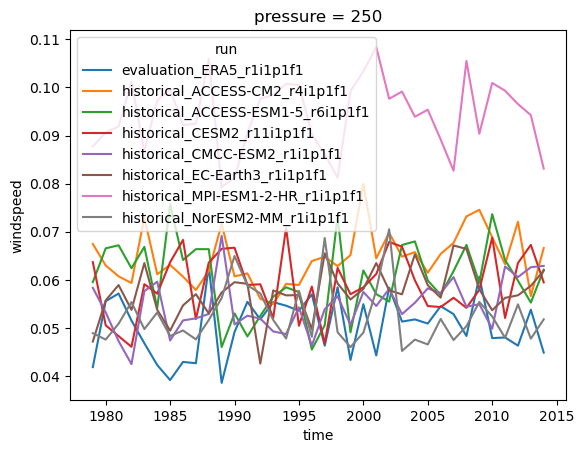

In [36]:
xr.plot.line(ds_results["windspeed"], x="time", hue="run", )

In [40]:
%%time
for run in i_future[1:]:
     experiment_id, source_id, member_id = run.split("_")
     name = f"{experiment_id}_{source_id}_{member_id}"
     print(name)
     results.append(delayed_results[name].compute())

ssp126_ACCESS-ESM1-5_r6i1p1f1
ssp126_CESM2_r11i1p1f1
ssp126_CMCC-ESM2_r1i1p1f1
ssp126_EC-Earth3_r1i1p1f1
ssp126_MPI-ESM1-2-HR_r1i1p1f1
ssp126_NorESM2-MM_r1i1p1f1
ssp370_ACCESS-CM2_r4i1p1f1
ssp370_ACCESS-ESM1-5_r6i1p1f1
ssp370_CESM2_r11i1p1f1
ssp370_CMCC-ESM2_r1i1p1f1
ssp370_EC-Earth3_r1i1p1f1
ssp370_MPI-ESM1-2-HR_r1i1p1f1
ssp370_NorESM2-MM_r1i1p1f1
ssp585_ACCESS-CM2_r4i1p1f1
ssp585_EC-Earth3_r1i1p1f1
CPU times: user 7min 22s, sys: 1min 26s, total: 8min 49s
Wall time: 33min 33s


In [41]:
ds_results = xr.concat(results, dim="run")
ds_results

<xarray.Dataset> Size: 26kB
Dimensions:    (run: 23, time: 122)
Coordinates:
  * time       (time) int64 976B 1979 1980 1981 1982 ... 2097 2098 2099 2100
    pressure   int64 8B 250
  * run        (run) <U33 3kB 'evaluation_ERA5_r1i1p1f1' ... 'ssp585_EC-Earth...
Data variables:
    windspeed  (run, time) float64 22kB 0.04186 0.05557 ... 0.06721 0.06027

In [42]:
ds_results.to_netcdf("/scratch/v46/gt3409/timeseries_windspeed_mog_p95_ann.nc")

In [63]:
ds_results = xr.open_dataset("/scratch/v46/gt3409/timeseries_windspeed_sog_p99_ann.nc")


In [61]:
list_evaluation = ['evaluation_ERA5_r1i1p1f1']

list_historical = ['historical_ACCESS-CM2_r4i1p1f1', 
                   'historical_ACCESS-ESM1-5_r6i1p1f1',
                   'historical_CESM2_r11i1p1f1', 
                   'historical_CMCC-ESM2_r1i1p1f1',
                   'historical_EC-Earth3_r1i1p1f1',
                   # 'historical_MPI-ESM1-2-HR_r1i1p1f1',
                   'historical_NorESM2-MM_r1i1p1f1',
                  ]

list_ssp126 = [
                 # 'ssp126_ACCESS-CM2_r4i1p1f1',
                 'ssp126_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp126_CESM2_r11i1p1f1',
                 'ssp126_CMCC-ESM2_r1i1p1f1',
                 'ssp126_EC-Earth3_r1i1p1f1',
                 # 'ssp126_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp126_NorESM2-MM_r1i1p1f1',
              ]

list_ssp370 = ['ssp370_ACCESS-CM2_r4i1p1f1',
                 'ssp370_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp370_CESM2_r11i1p1f1',
                 'ssp370_CMCC-ESM2_r1i1p1f1',
                 'ssp370_EC-Earth3_r1i1p1f1',
                 # 'ssp370_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp370_NorESM2-MM_r1i1p1f1',
              ]

list_ssp585 = ['ssp585_ACCESS-CM2_r4i1p1f1',
                 'ssp585_EC-Earth3_r1i1p1f1']

In [64]:
ds_results.sel(run = list_evaluation + 
               list_historical + 
               list_ssp126 + 
               list_ssp370 +
               list_ssp585)

<xarray.Dataset> Size: 23kB
Dimensions:    (run: 20, time: 122)
Coordinates:
  * time       (time) int64 976B 1979 1980 1981 1982 ... 2097 2098 2099 2100
    pressure   int64 8B ...
  * run        (run) <U33 3kB 'evaluation_ERA5_r1i1p1f1' ... 'ssp585_EC-Earth...
Data variables:
    windspeed  (run, time) float64 20kB ...

In [69]:
ssp_colors = {"evaluation":"k",
              "historical":"grey",
              "ssp585":(149/255,27/255,30/255),
              "ssp370":(231/255,29/255,37/255),
              "ssp245":(247/255,148/255,32/255),
              "ssp126":(23/255,60/255,102/255),
              "ssp119":(0/255,173/255,207/255),}


In [85]:
df = ds_results.sel(run = list_evaluation + 
               list_historical + 
               list_ssp126 + 
               list_ssp370 +
               list_ssp585).to_dataframe()["windspeed"].reset_index()
df["experiment"] = [x.split("_")[0] for x in df["run"]]


In [86]:
window_size = 5
df["rolling_5y"] = df["windspeed"].rolling(window=window_size,).mean()
df

,run,time,windspeed,experiment,rolling_5y
0,evaluation_ERA5_r1i1p1f1,1979,0.007557,evaluation,NaN
1,evaluation_ERA5_r1i1p1f1,1980,0.010183,evaluation,NaN
2,evaluation_ERA5_r1i1p1f1,1981,0.013002,evaluation,NaN
3,evaluation_ERA5_r1i1p1f1,1982,0.010645,evaluation,NaN
4,evaluation_ERA5_r1i1p1f1,1983,0.008611,evaluation,0.010000
...,...,...,...,...,...
2435,ssp585_EC-Earth3_r1i1p1f1,2096,0.015154,ssp585,0.017109
2436,ssp585_EC-Earth3_r1i1p1f1,2097,0.013832,ssp585,0.016051
2437,ssp585_EC-Earth3_r1i1p1f1,2098,0.015990,ssp585,0.014930
2438,ssp585_EC-Earth3_r1i1p1f1,2099,0.016576,ssp585,0.015870


<Axes: xlabel='time', ylabel='windspeed'>

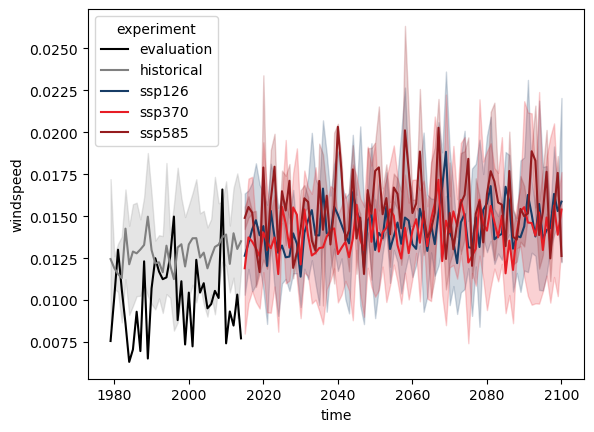

In [87]:
sns.lineplot(df, x="time", y="windspeed", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)


<Axes: xlabel='time', ylabel='rolling_5y'>

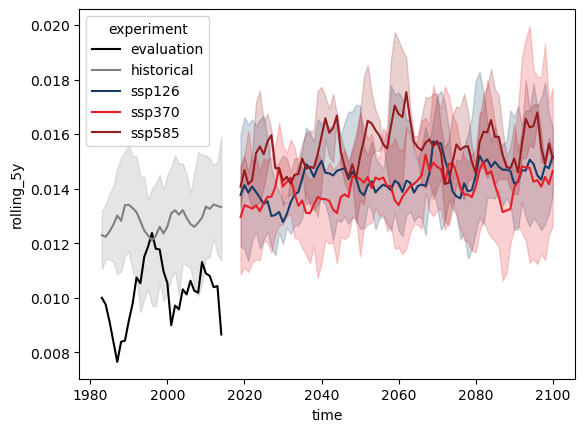

In [88]:
sns.lineplot(df, x="time", y="rolling_5y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors)

In [68]:
list_ssp126 = ['ssp126_ACCESS-CM2_r4i1p1f1',
                 'ssp126_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp126_CESM2_r11i1p1f1',
                 'ssp126_CMCC-ESM2_r1i1p1f1',
                 'ssp126_EC-Earth3_r1i1p1f1',
                 'ssp126_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp126_NorESM2-MM_r1i1p1f1',]

list_ssp370 = ['ssp370_ACCESS-CM2_r4i1p1f1',
                 'ssp370_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp370_CESM2_r11i1p1f1',
                 'ssp370_CMCC-ESM2_r1i1p1f1',
                 'ssp370_EC-Earth3_r1i1p1f1',
                 'ssp370_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp370_NorESM2-MM_r1i1p1f1',]

list_ssp585 = ['ssp585_ACCESS-CM2_r4i1p1f1',
                 'ssp585_EC-Earth3_r1i1p1f1']

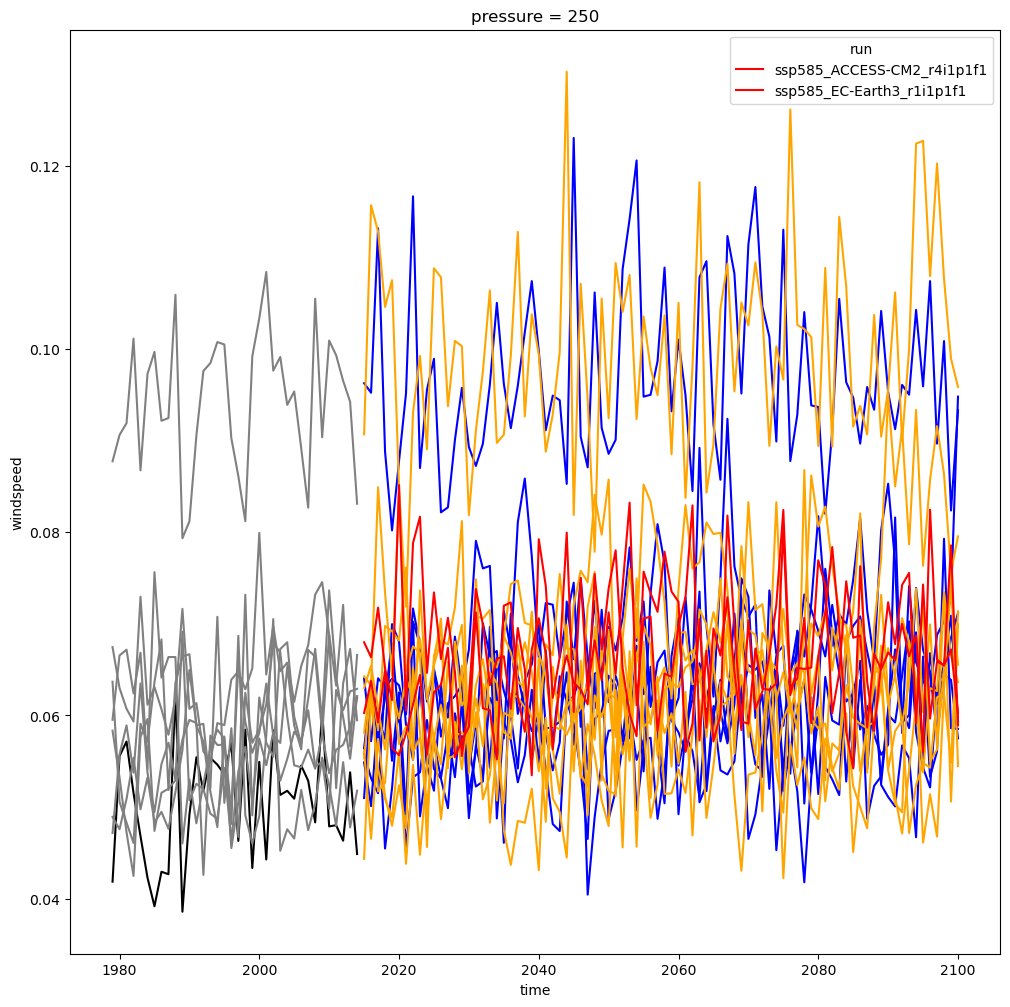

In [70]:
xr.plot.line(ds_results.sel({"run": list(i_evaluation)})["windspeed"], x="time", hue="run", figsize=(12,12), color="k" );
xr.plot.line(ds_results.sel({"run": list(i_historical)})["windspeed"], x="time", hue="run", color="grey",  );
xr.plot.line(ds_results.sel({"run": list_ssp126[1:]})["windspeed"], x="time", hue="run", color="blue",  );
xr.plot.line(ds_results.sel({"run": list_ssp370})["windspeed"], x="time", hue="run", color="orange",  );
xr.plot.line(ds_results.sel({"run": list_ssp585})["windspeed"], x="time", hue="run", color="r",  );

In [18]:
/

()

In [10]:
delayed_results = {}

In [11]:
%%time
turbulence_index = "windspeed"
for run in i_evaluation:
    experiment_id, source_id, member_id = run.split("_")
    name = f"{experiment_id}_{source_id}_{member_id}"
    print(name)
    time_range = np.arange(1979,2014+1)
    # time_range = np.arange(1979,2022+1)
    
    filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
     for year in time_range]
    
    def _preprocess(ds):
        return (ds.sel(lat=slice(-60,-30))>sog).mean(["time", "lat", "lon"])
    
    ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, combine="nested", 
                           concat_dim="time").assign_coords({"run":name})
    ds["time"] = time_range
    # ds = ds.compute()
    delayed_results[name] = ds

evaluation_ERA5_r1i1p1f1
CPU times: user 1.31 s, sys: 268 ms, total: 1.58 s
Wall time: 1.95 s


In [12]:
%%time
turbulence_index = "windspeed"
for run in i_historical:
    experiment_id, source_id, member_id = run.split("_")
    name = f"{experiment_id}_{source_id}_{member_id}"
    print(name)
    time_range = np.arange(1979,2014+1)
    
    filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
     for year in time_range]
    
    def _preprocess(ds):
        return (ds.sel(lat=slice(-60,-30))>sog).mean(["time", "lat", "lon"])
    
    ds = xr.open_mfdataset(filelist, use_cftime=True,
                           preprocess=_preprocess, combine="nested", 
                           concat_dim="time").assign_coords({"run":name})
    ds["time"] = time_range
    # ds = ds.compute()
    delayed_results[name] = ds


historical_ACCESS-CM2_r4i1p1f1
historical_ACCESS-ESM1-5_r6i1p1f1
historical_CESM2_r11i1p1f1
historical_CMCC-ESM2_r1i1p1f1
historical_EC-Earth3_r1i1p1f1
historical_MPI-ESM1-2-HR_r1i1p1f1
historical_NorESM2-MM_r1i1p1f1
CPU times: user 8.83 s, sys: 2.02 s, total: 10.8 s
Wall time: 16.3 s


In [13]:
%%time
turbulence_index = "windspeed"
for run in i_future[1:]:
    experiment_id, source_id, member_id = run.split("_")
    name = f"{experiment_id}_{source_id}_{member_id}"
    print(name)
    time_range = np.arange(2015,2100+1)
    
    filelist = [f"/scratch/v46/gt3409/TMP_{turbulence_index}_AUS-15_{source_id}_{experiment_id}_{member_id}_BOM_BARPA-R_v1-r1_6hr_{year}.nc" 
     for year in time_range]
    
    def _preprocess(ds):
        return (ds.sel(lat=slice(-60,-30))>sog).mean(["time", "lat", "lon"])
    
    ds = xr.open_mfdataset(filelist, use_cftime=True, preprocess=_preprocess, 
                           combine="nested", concat_dim="time").assign_coords({"run":name})
    ds["time"] = time_range
    # ds = ds.compute()
    delayed_results[name] = ds


ssp126_ACCESS-ESM1-5_r6i1p1f1
ssp126_CESM2_r11i1p1f1
ssp126_CMCC-ESM2_r1i1p1f1
ssp126_EC-Earth3_r1i1p1f1
ssp126_MPI-ESM1-2-HR_r1i1p1f1
ssp126_NorESM2-MM_r1i1p1f1
ssp370_ACCESS-CM2_r4i1p1f1
ssp370_ACCESS-ESM1-5_r6i1p1f1
ssp370_CESM2_r11i1p1f1
ssp370_CMCC-ESM2_r1i1p1f1
ssp370_EC-Earth3_r1i1p1f1
ssp370_MPI-ESM1-2-HR_r1i1p1f1
ssp370_NorESM2-MM_r1i1p1f1
ssp585_ACCESS-CM2_r4i1p1f1
ssp585_EC-Earth3_r1i1p1f1
CPU times: user 42.8 s, sys: 9.26 s, total: 52 s
Wall time: 1min 16s


In [14]:
%%time
results = []
for run in i_evaluation:
     experiment_id, source_id, member_id = run.split("_")
     name = f"{experiment_id}_{source_id}_{member_id}"
     print(name)
     results.append(delayed_results[name].compute())

evaluation_ERA5_r1i1p1f1
CPU times: user 8.57 s, sys: 1.5 s, total: 10.1 s
Wall time: 43.3 s


In [15]:
%%time
for run in i_historical:
     experiment_id, source_id, member_id = run.split("_")
     name = f"{experiment_id}_{source_id}_{member_id}"
     print(name)
     results.append(delayed_results[name].compute())

historical_ACCESS-CM2_r4i1p1f1
historical_ACCESS-ESM1-5_r6i1p1f1
historical_CESM2_r11i1p1f1
historical_CMCC-ESM2_r1i1p1f1
historical_EC-Earth3_r1i1p1f1
historical_MPI-ESM1-2-HR_r1i1p1f1
historical_NorESM2-MM_r1i1p1f1
CPU times: user 1min 17s, sys: 12.2 s, total: 1min 29s
Wall time: 5min 38s


In [22]:
ds_results = xr.concat(results, dim="run")
ds_results

<xarray.Dataset> Size: 4kB
Dimensions:    (run: 8, time: 36)
Coordinates:
    pressure   int64 8B 250
  * run        (run) <U33 1kB 'evaluation_ERA5_r1i1p1f1' ... 'historical_NorE...
  * time       (time) int64 288B 1979 1980 1981 1982 ... 2011 2012 2013 2014
Data variables:
    windspeed  (run, time) float64 2kB 0.04186 0.05557 ... 0.04777 0.05179

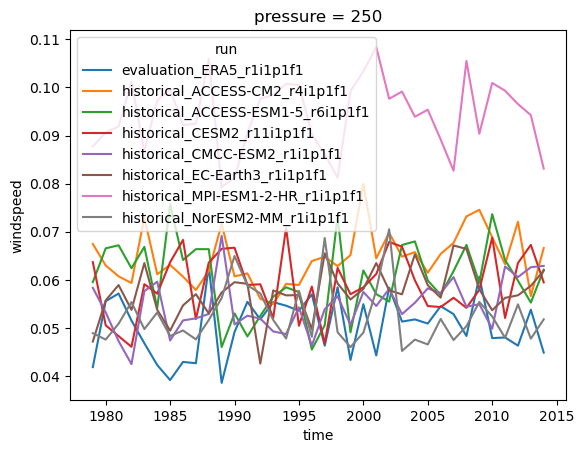

In [36]:
xr.plot.line(ds_results["windspeed"], x="time", hue="run", )

In [40]:
%%time
for run in i_future[1:]:
     experiment_id, source_id, member_id = run.split("_")
     name = f"{experiment_id}_{source_id}_{member_id}"
     print(name)
     results.append(delayed_results[name].compute())

ssp126_ACCESS-ESM1-5_r6i1p1f1
ssp126_CESM2_r11i1p1f1
ssp126_CMCC-ESM2_r1i1p1f1
ssp126_EC-Earth3_r1i1p1f1
ssp126_MPI-ESM1-2-HR_r1i1p1f1
ssp126_NorESM2-MM_r1i1p1f1
ssp370_ACCESS-CM2_r4i1p1f1
ssp370_ACCESS-ESM1-5_r6i1p1f1
ssp370_CESM2_r11i1p1f1
ssp370_CMCC-ESM2_r1i1p1f1
ssp370_EC-Earth3_r1i1p1f1
ssp370_MPI-ESM1-2-HR_r1i1p1f1
ssp370_NorESM2-MM_r1i1p1f1
ssp585_ACCESS-CM2_r4i1p1f1
ssp585_EC-Earth3_r1i1p1f1
CPU times: user 7min 22s, sys: 1min 26s, total: 8min 49s
Wall time: 33min 33s


In [41]:
ds_results = xr.concat(results, dim="run")
ds_results

<xarray.Dataset> Size: 26kB
Dimensions:    (run: 23, time: 122)
Coordinates:
  * time       (time) int64 976B 1979 1980 1981 1982 ... 2097 2098 2099 2100
    pressure   int64 8B 250
  * run        (run) <U33 3kB 'evaluation_ERA5_r1i1p1f1' ... 'ssp585_EC-Earth...
Data variables:
    windspeed  (run, time) float64 22kB 0.04186 0.05557 ... 0.06721 0.06027

In [42]:
ds_results.to_netcdf("/scratch/v46/gt3409/timeseries_windspeed_sog_p99_ann.nc")

In [68]:
list_ssp126 = ['ssp126_ACCESS-CM2_r4i1p1f1',
                 'ssp126_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp126_CESM2_r11i1p1f1',
                 'ssp126_CMCC-ESM2_r1i1p1f1',
                 'ssp126_EC-Earth3_r1i1p1f1',
                 'ssp126_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp126_NorESM2-MM_r1i1p1f1',]

list_ssp370 = ['ssp370_ACCESS-CM2_r4i1p1f1',
                 'ssp370_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp370_CESM2_r11i1p1f1',
                 'ssp370_CMCC-ESM2_r1i1p1f1',
                 'ssp370_EC-Earth3_r1i1p1f1',
                 'ssp370_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp370_NorESM2-MM_r1i1p1f1',]

list_ssp585 = ['ssp585_ACCESS-CM2_r4i1p1f1',
                 'ssp585_EC-Earth3_r1i1p1f1']

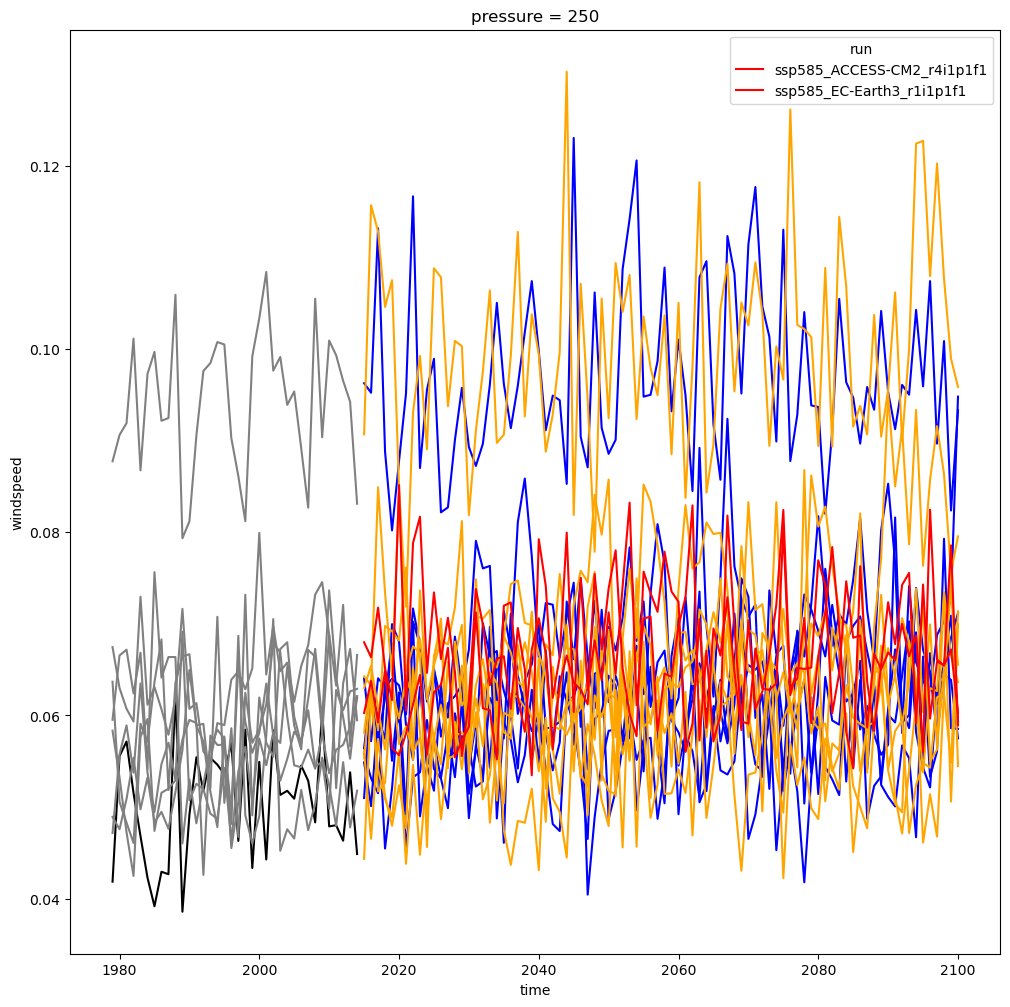

In [70]:
xr.plot.line(ds_results.sel({"run": list(i_evaluation)})["windspeed"], x="time", hue="run", figsize=(12,12), color="k" );
xr.plot.line(ds_results.sel({"run": list(i_historical)})["windspeed"], x="time", hue="run", color="grey",  );
xr.plot.line(ds_results.sel({"run": list_ssp126[1:]})["windspeed"], x="time", hue="run", color="blue",  );
xr.plot.line(ds_results.sel({"run": list_ssp370})["windspeed"], x="time", hue="run", color="orange",  );
xr.plot.line(ds_results.sel({"run": list_ssp585})["windspeed"], x="time", hue="run", color="r",  );

In [71]:
/\

SyntaxError: unexpected character after line continuation character (3227224339.py, line 1)

In [19]:
for run in i_evaluation:
     experiment_id, source_id, member_id = run.split("_")
     print(f"{experiment_id}_{source_id}_{member_id}")

evaluation_ERA5_r1i1p1f1


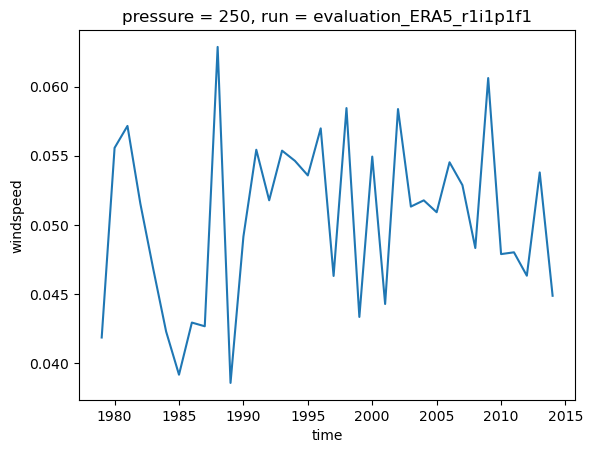

In [20]:
results[0]["windspeed"].plot()